# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('C:/Users/raulg/OneDrive/Documentos/Proyectos DS/taxi.csv')
data.head()


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data = data.sort_index()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data_hourly = data.resample('1H').sum()
data_hourly.head()

C:\Users\raulg\AppData\Local\Temp\ipykernel_31044\2026576773.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly = data.resample('1H').sum()


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
data_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Análisis

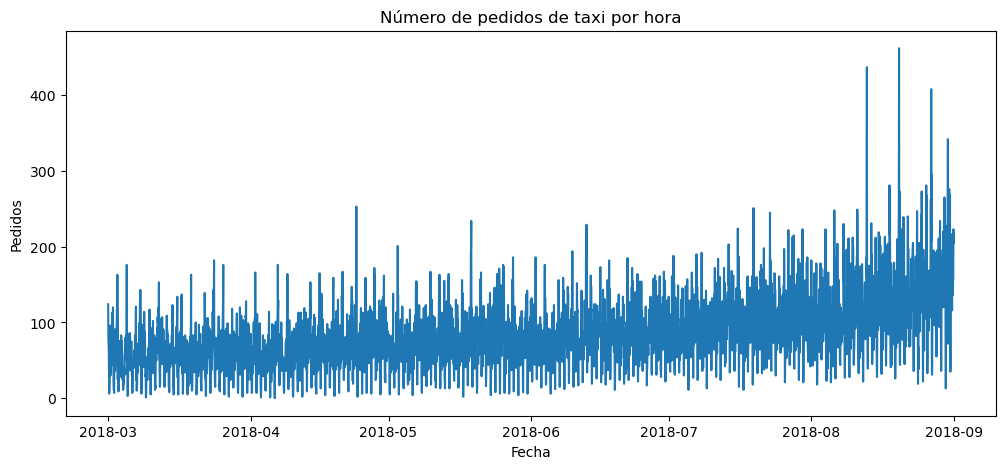

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(data_hourly['num_orders'])
plt.title('Número de pedidos de taxi por hora')
plt.xlabel('Fecha')
plt.ylabel('Pedidos')
plt.show()

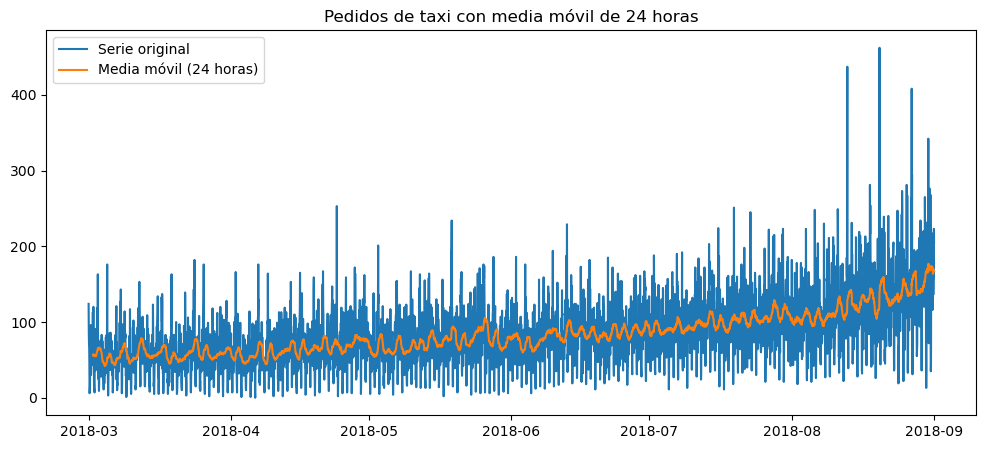

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(data_hourly['num_orders'], label='Serie original')
plt.plot(
    data_hourly['num_orders'].rolling(24).mean(),
    label='Media móvil (24 horas)'
)
plt.legend()
plt.title('Pedidos de taxi con media móvil de 24 horas')
plt.show()

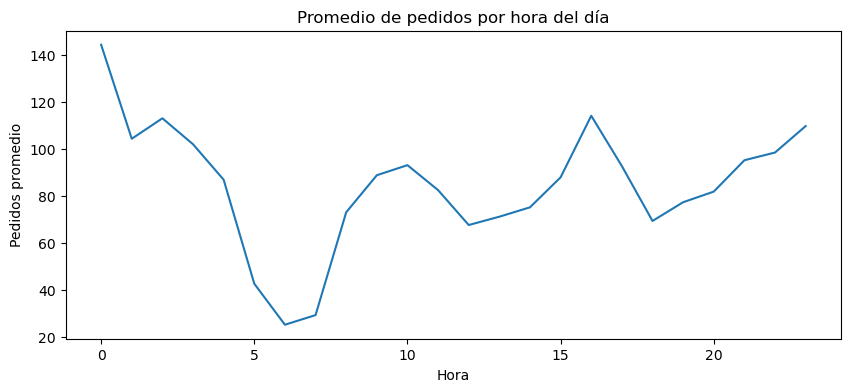

In [9]:
data_hourly['hour'] = data_hourly.index.hour

hourly_mean = data_hourly.groupby('hour')['num_orders'].mean()

plt.figure(figsize=(10, 4))
hourly_mean.plot()
plt.title('Promedio de pedidos por hora del día')
plt.xlabel('Hora')
plt.ylabel('Pedidos promedio')
plt.show()

## Formación

In [10]:
data_ml = data_hourly.copy()

# Crear lags
for lag in [1, 2, 3, 24]:
    data_ml[f'lag_{lag}'] = data_ml['num_orders'].shift(lag)

# Medias móviles
data_ml['rolling_mean_3'] = data_ml['num_orders'].shift(1).rolling(3).mean()
data_ml['rolling_mean_24'] = data_ml['num_orders'].shift(1).rolling(24).mean()

data_ml.head()

,num_orders,hour,lag_1,lag_2,lag_3,lag_24,rolling_mean_3,rolling_mean_24
datetime,,,,,,,,
2018-03-01 00:00:00,124,0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,93.333333,NaN
2018-03-01 04:00:00,43,4,66.0,71.0,85.0,NaN,74.000000,NaN


In [11]:
data_ml['hour'] = data_ml.index.hour
data_ml['dayofweek'] = data_ml.index.dayofweek

In [12]:
data_ml = data_ml.dropna()
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_orders       4392 non-null   int64  
 1   hour             4392 non-null   int32  
 2   lag_1            4392 non-null   float64
 3   lag_2            4392 non-null   float64
 4   lag_3            4392 non-null   float64
 5   lag_24           4392 non-null   float64
 6   rolling_mean_3   4392 non-null   float64
 7   rolling_mean_24  4392 non-null   float64
 8   dayofweek        4392 non-null   int32  
dtypes: float64(6), int32(2), int64(1)
memory usage: 308.8 KB


In [13]:
# Definir características y objetivo
X = data_ml.drop('num_orders', axis=1)
y = data_ml['num_orders']

# Separación temporal (sin shuffle)
train_size = int(len(data_ml) * 0.9)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print(X_train.shape, X_test.shape)

(3952, 8) (440, 8)


In [18]:
# Baseline: valor de la hora anterior
y_pred_baseline = X_test['lag_1']

rmse_baseline = mean_squared_error(y_test, y_pred_baseline) ** 0.5
rmse_baseline

58.881776776551476

In [19]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

rmse_lr = mean_squared_error(y_test, y_pred_lr) ** 0.5
rmse_lr

47.16079627319969

In [20]:
from sklearn.ensemble import RandomForestRegressor

rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
rmse_rf

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_lr = mean_squared_error(y_test, y_pred_lr) ** 0.5
rmse_lr

47.16079627319969

In [21]:
results = pd.DataFrame({
    'Modelo': ['Baseline', 'Regresión Lineal', 'Random Forest'],
    'RMSE': [rmse_baseline, rmse_lr, rmse_rf]
})

results

,Modelo,RMSE
0,Baseline,58.881777
1,Regresión Lineal,47.160796
2,Random Forest,46.218681


## Prueba

In [22]:
best_model = rf_model
y_pred = y_pred_rf

In [23]:
rmse_lr = mean_squared_error(y_test, y_pred_lr) ** 0.5
rmse_lr

47.16079627319969

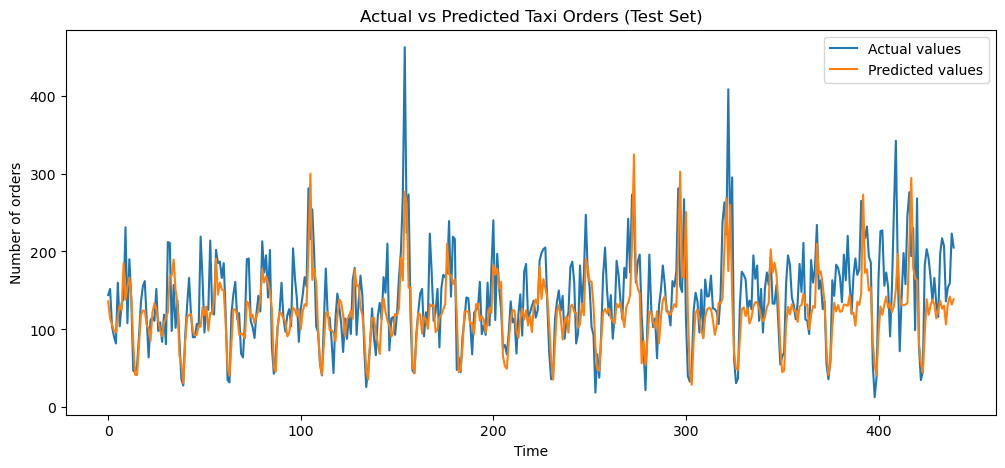

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(y_test.values, label='Actual values')
ax.plot(y_pred, label='Predicted values')

ax.set_title('Actual vs Predicted Taxi Orders (Test Set)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of orders')
ax.legend()

# Guardar ANTES de cerrar la figura
fig.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close(fig)

### Conclusiones

Se construyó un modelo de machine learning para predecir la cantidad de pedidos de taxi
para la próxima hora utilizando datos históricos. Tras comparar varios modelos, el
Random Forest mostró el mejor desempeño en el conjunto de prueba, alcanzando un valor
de RECM inferior a 48, lo que cumple con el criterio establecido.

El modelo captura adecuadamente la estacionalidad diaria y semanal de la serie temporal,
lo que lo convierte en una herramienta útil para anticipar la demanda durante horas pico.